<a href="https://colab.research.google.com/github/alanwuha/ce7455-nlp/blob/master/assignment-3/nlp-from-scratch-translation-with-a-sequence-to-sequence-network-and-attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION

### Import Modules

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load and Prepare Data

The data for this project is a set of many thousands of English to French translation pairs.

In [5]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-04-06 10:39:03--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.8.24, 13.224.8.129, 13.224.8.47, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.8.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  6.25MB/s    in 0.4s    

2020-04-06 10:39:04 (6.25 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

In [0]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = { 0: 'SOS', 1: 'EOS' }
        self.n_words = 2 # Count SOS and EOS
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
print(unicodeToAscii("À l'aide !"))
print(normalizeString("À l'aide !"))

print(normalizeString("Go."))
print(normalizeString("Va !"))

A l'aide !
a l aide !
go .
va !


In [0]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p): # e.g. p = ['go.', 'va !']
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [0]:
def wordIndexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = wordIndexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
def readLangs(lang1, lang2, reverse=False): # e.g. lang1 = eng, lang2 = fra
    print("Reading lines...")
    
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
        input_char = Char(lang2)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        input_char = Char(lang1)
        
    return input_lang, output_lang, input_char, pairs

### The Decoder

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

### The Attention Decoder

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Plotting results

Plotting is done with matplotlib, using the array of loss values `plot_losses` saved while training.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    print('showPlot')
    plt.figure()
    fig, ax = plt.subplots()
    # this locater puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [0]:
import time

def asMinutes(s):
    m = s // 60
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    # return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    return '%s' % (asMinutes(s))

## Here's What's Changed

### The CNN Model for Generating Character Embeddings

Consider the word 'cat', we pad it on both ends to get our maximum word length (this is mainly an implementation quirk since we can't have variable length layers at run time, our algorithm will ignore the pads).

We then apply a convolution layer on top that generates spatial coherence across characters, we use a maxpool to extract meaningful features out of our convolution layer. This now gives us a dense vector representation of each word.

__This representation will then be concatenated with the word embedding to become the input of the GRU layer in EncoderRNN__.

![cnn_model](https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/images/cnn_model.png)

This snippet shows us how the CNN is implemented in PyTorch.

```
self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=char_representation_dim, kernel_size=(3, char_embedding_dim), padding=(2, 0))
```

We define a new `Char` class that stores the char2index, char2count, and index2char dictionaries for a given language to be used for character-level encoding.

In [0]:
EOS_char_token = 0

class Char:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: '*'}
        self.n_chars = 1
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        for char in word:
            self.addChar(char)
            
    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

We add two new methods `charIndexesFromSentence` and `charIndexesFromWord` to retrieve character indexes for a given input sentence to be used for our character-level encoding.

In [0]:
def charIndexesFromSentence(char, sentence):
    indexes = [charIndexesFromWord(char, word) for word in sentence.split(' ')]
    indexes.append([EOS_char_token])
    return indexes

def charIndexesFromWord(char, word):
    return [char.char2index[character] for character in word]

### The Encoder

We modify the original EncoderRNN to include a character-level encoder that generates character representation given an input word. This character representation will then be concatenated with the word embedding and passed as input into the GRU layer to generate the output and hidden vectors for each word in a sequence.

![diagram](/content/encoder.jpg)

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, n_chars, n_words, hidden_size, char_embedding_dim=25, char_representation_dim=25):
        """
        Input parameters:
            n_chars = Number of unique characters in input language
            n_words = Number of unique words in input language
            hidden_size = Dimension of GRU input and output.
            char_embedding_dim = Dimension of the character embeddings
            char_representation_dim = Output dimension from the CNN encoder for character
        """
        super(EncoderRNN, self).__init__()

        # Parameters
        self.n_chars = n_chars
        self.char_embedding_dim = char_embedding_dim
        self.char_representation_dim = char_representation_dim
        self.n_words = n_words
        self.hidden_size = hidden_size

        # Character-level encoder
        self.char_embedding_layer = nn.Embedding(n_chars, char_embedding_dim)
        self.char_cnn3_layer = nn.Conv2d(in_channels=1, out_channels=char_representation_dim, kernel_size=(3, char_embedding_dim), padding=(2, 0))
        
        # Word embedding layer (Dimension of the word embeddings is automatically derived as hidden_size - char_representation_dim)
        self.word_embedding_layer = nn.Embedding(n_words, hidden_size - char_representation_dim)
        
        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size)

        # Weights
        self.initEmbedding(self.char_embedding_layer.weight)
        
    def forward(self, char_indexes, word_index, hidden):
        # Get char representation
        char_embedding = self.char_embedding_layer(char_indexes).unsqueeze(1)
        char_cnn3 = self.char_cnn3_layer(char_embedding).squeeze(-1).unsqueeze(1)
        char_representation = F.max_pool2d(char_cnn3, kernel_size=(1, char_cnn3.size(-1))).squeeze(-1)

        # Get word embedding
        word_embedding = self.word_embedding_layer(word_index).view(1, 1, -1)

        # Concatenate char representation with word embedding
        combined = torch.cat((char_representation, word_embedding), dim=2)

        # Feed combined and hidden to GRU
        output, hidden = self.gru(combined, hidden)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def initEmbedding(self, input_embedding):
      """
      Initialize embedding
      """
      bias = np.sqrt(3.0 / input_embedding.size(1))
      nn.init.uniform_(input_embedding, -bias, bias)

### Decoder Beam Search

We implement a new class `BeamSearchNode` and new method `BeamDecode` to perform beam search decoding in our decoder model.

In [0]:
class BeamSearchNode(object):
  def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
    self.h = hiddenstate
    self.prevNode = previousNode
    self.wordid = wordId
    self.logp = logProb
    self.leng = length

  def eval(self, alpha=1.0):
    reward = 0
    # Add here a function for shaping a reward

    return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward

In [0]:
import operator
from queue import PriorityQueue

def beamDecode(decoder_hiddens, decoder, encoder_outputs=None):
  """
  :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
  :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
  :return: decoded_batch
  """

  beam_width = 5
  topk = 1 # how many sentences do you want to generate
  decoded_batch = []

  # print(target_tensor.shape)
  # print(decoder_hiddens.shape)
  # print(encoder_outputs.shape)

  # decoding goes sentence by sentence
  for idx in range(decoder_hiddens.size(1)):
    decoder_hidden = decoder_hiddens[:, idx, :]
    encoder_output = encoder_outputs[:, idx, :]

    # Start with the start of the sentence token
    decoder_input = torch.LongTensor([[SOS_token]]).to(device)
    
    # Number of sentence to generate
    endnodes = []
    number_required = min((topk + 1), topk - len(endnodes))

    # Starting node - hidden vector, previous node, word id, logp, length
    node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
    nodes = PriorityQueue()

    # Start the queue
    nodes.put((-node.eval(), node))
    qsize = 1

    # Start beam search
    while True:

      # Give up when decoding takes too long
      if qsize > 2000:
        break

      # Fetch the best node
      score, n = nodes.get()
      decoder_input = n.wordid
      decoder_hidden = n.h

      if n.wordid.item() == EOS_token and n.prevNode != None:
        endnodes.append((score, n))
        # If we reached maximum # of sentences required
        if len(endnodes) >= number_required:
          break
        else:
          continue

      # Decode for one step using decoder
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)

      # PUT HERE REAL BEAM SEARCH OF TOP
      log_prob, indexes = torch.topk(decoder_output, beam_width)
      # print(indexes)
      nextnodes = []

      for new_k in range(beam_width):
        decoded_t = indexes[0][new_k].view(1, -1)
        log_p = log_prob[0][new_k].item()

        node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)
        score = -node.eval()
        nextnodes.append((score, node))

      # Put them into queue
      for i in range(len(nextnodes)):
        score, nn = nextnodes[i]
        nodes.put((score, nn))
        # increase qsize
      qsize += len(nextnodes) - 1

    # Choose nbest paths, back trace them
    if len(endnodes) == 0:
      endnodes = [nodes.get() for _ in range(topk)]

    utterances = []
    for score, n in sorted(endnodes, key=operator.itemgetter(0)):
      utterance = []
      utterance.append(n.wordid)
      # back trace
      while n.prevNode != None:
        n = n.prevNode
        utterance.append(n.wordid)

      utterance = utterance[::-1]
      utterances.append(utterance)
    
    decoded_batch.append(utterances)

  return decoded_batch

### Preparing the train and test data

We modify `prepareData` to:
1. Generate `input_char`
1. Shuffle `pairs`
1. Split `pairs` into `train_pairs` (80% of total pairs) and `test_pairs` (20% of total pairs).

In [21]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, input_char, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words and chars...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        input_char.addSentence(pair[0])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    print("Counted chars:")
    print(input_char.name, input_char.n_chars)
    print('%d total pairs' % (len(pairs),))

    # Shuffle pairs and split into train_pairs and test_pairs
    random.shuffle(pairs)
    train_length = (len(pairs) // 10) * 8
    train_pairs = pairs[:train_length]
    test_pairs = pairs[train_length:]
    
    return input_lang, output_lang, input_char, train_pairs, test_pairs

input_lang, output_lang, input_char, train_pairs, test_pairs = prepareData('eng', 'fra', True)

print('\nCounting total pairs, train pairs, and test pairs...')
print('%d train pairs' % (len(train_pairs),))
print('%d test pairs' % (len(test_pairs),))
print('Example of a training pair: %s' % (train_pairs[0]))

print('\nTesting charIndexesFromSentence...')
sentence = 'je t aime'
print('Sentence: %s' % (sentence))
print('Char Indexes: %s' % (charIndexesFromSentence(input_char, sentence)))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words and chars...
Counted words:
fra 4345
eng 2803
Counted chars:
fra 30
10599 total pairs

Counting total pairs, train pairs, and test pairs...
8472 train pairs
2127 test pairs
Example of a training pair: ['je ne suis pas assure .', 'i m uninsured .']

Testing charIndexesFromSentence...
Sentence: je t aime
Char Indexes: [[1, 7], [17], [2, 3, 16, 7], [0]]


There are a total of `29` unique characters (excluding the EOS_char_token '*' that we added)  in the `French` dataset as shown below.

In [22]:
print(input_char.char2index)
print(input_char.char2count)
print(input_char.index2char)
print(len(input_char.char2index))

{'j': 1, 'a': 2, 'i': 3, 'n': 4, 's': 5, '.': 6, 'e': 7, 'v': 8, 'b': 9, 'c': 10, 'u': 11, 'g': 12, 'r': 13, 'o': 14, 'f': 15, 'm': 16, 't': 17, 'h': 18, '!': 19, 'l': 20, 'd': 21, 'p': 22, 'z': 23, 'x': 24, 'y': 25, 'q': 26, 'k': 27, '?': 28, 'w': 29}
{'j': 4774, 'a': 13819, 'i': 15983, 'n': 15628, 's': 27771, '.': 10262, 'e': 40222, 'v': 4630, 'b': 1642, 'c': 5537, 'u': 16566, 'g': 1742, 'r': 12076, 'o': 13499, 'f': 2316, 'm': 6719, 't': 15608, 'h': 1468, '!': 197, 'l': 9856, 'd': 5313, 'p': 6098, 'z': 407, 'x': 747, 'y': 415, 'q': 1192, 'k': 37, '?': 145, 'w': 13}
{0: '*', 1: 'j', 2: 'a', 3: 'i', 4: 'n', 5: 's', 6: '.', 7: 'e', 8: 'v', 9: 'b', 10: 'c', 11: 'u', 12: 'g', 13: 'r', 14: 'o', 15: 'f', 16: 'm', 17: 't', 18: 'h', 19: '!', 20: 'l', 21: 'd', 22: 'p', 23: 'z', 24: 'x', 25: 'y', 26: 'q', 27: 'k', 28: '?', 29: 'w'}
29


In the `train` method, we modify the encoder's forward pass method (line 24) to take in character indexes for each input word.

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, input_char_indexes, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # Modify encoder forward pass method to take in character indexes of the input word
        encoder_output, encoder_hidden = encoder(torch.LongTensor([input_char_indexes[ei]]).to(device), input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # Train using DecoderRNN
            # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            # Train using AttnDecoderRNN
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, target_tensor[di])

            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # Train using DecoderRNN
            # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            # Train using AttnDecoderRNN
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

We define a new method `trainEpochs` to train on `train_pairs` (80% of the data) and evaluate on `test_pairs` (20% of the data) for a given number of epochs.

In [0]:
def trainEpochs(encoder, decoder, n_epochs=20, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    # Train over n_epochs
    for epoch in range(n_epochs):

        # Print start of epoch
        print('Epoch %d' % (epoch))

        # Shuffle train_pairs
        random.shuffle(train_pairs)

        # Get tensors from pair
        training_pairs = [tensorsFromPair(pair) for pair in train_pairs]
        
        # Get character indexes
        training_char_indexes = [charIndexesFromSentence(input_char, pair[0]) for pair in train_pairs]

        # Train all train_pairs
        for i in range(1, len(train_pairs) + 1):
        # for i in range(1, 2):
          training_pair = training_pairs[i - 1]
          input_tensor = training_pair[0]
          target_tensor = training_pair[1]
          input_char_indexes = training_char_indexes[i - 1]

          loss = train(input_tensor, target_tensor, input_char_indexes, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
          print_loss_total += loss
          plot_loss_total += loss

          if i % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, i / len(train_pairs)), i, i / len(train_pairs) * 100, print_loss_avg))
            
          if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

We modify the `Evaluate` method to perform beam search decoding to generate the output sequences.

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_lang, sentence)
    input_length = input_tensor.size()[0]
    encoder_hidden = encoder.initHidden()
    
    input_char_indexes = charIndexesFromSentence(input_char, sentence)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(torch.LongTensor([input_char_indexes[ei]]).to(device), input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_output[0, 0]

    decoder_hidden = encoder_hidden

    decoded_batch = beamDecode(decoder_hidden.unsqueeze(1), decoder, encoder_outputs.unsqueeze(1))
    
    return decoded_batch

### Train our improved model on train data (80% of total data)

Epoch 0
0m 20s (1000 11%) 3.5510
0m 40s (2000 23%) 2.9484
1m 0s (3000 35%) 2.7774
1m 19s (4000 47%) 2.6384
1m 39s (5000 59%) 2.5778
1m 59s (6000 70%) 2.5587
2m 20s (7000 82%) 2.4001
2m 40s (8000 94%) 2.3173
Epoch 1
3m 10s (1000 11%) 3.2584
3m 31s (2000 23%) 2.0728
3m 51s (3000 35%) 2.0870
4m 11s (4000 47%) 2.0718
4m 31s (5000 59%) 2.0796
4m 51s (6000 70%) 2.0365
5m 11s (7000 82%) 1.9713
5m 31s (8000 94%) 1.9175
Epoch 2
6m 2s (1000 11%) 2.6240
6m 22s (2000 23%) 1.6793
6m 42s (3000 35%) 1.6784
7m 3s (4000 47%) 1.6628
7m 23s (5000 59%) 1.7078
7m 44s (6000 70%) 1.5795
8m 4s (7000 82%) 1.6722
8m 25s (8000 94%) 1.6141
Epoch 3
8m 55s (1000 11%) 2.1427
9m 15s (2000 23%) 1.2975
9m 36s (3000 35%) 1.3260
9m 56s (4000 47%) 1.3424
10m 17s (5000 59%) 1.3485
10m 38s (6000 70%) 1.3758
10m 58s (7000 82%) 1.3597
11m 19s (8000 94%) 1.3233
Epoch 4
11m 50s (1000 11%) 1.6950
12m 10s (2000 23%) 1.0890
12m 32s (3000 35%) 1.0748
12m 52s (4000 47%) 1.1106
13m 13s (5000 59%) 1.1103
13m 34s (6000 70%) 1.0686
13m 

<Figure size 432x288 with 0 Axes>

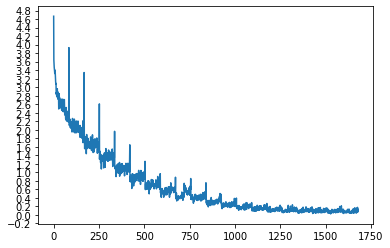

In [26]:
hidden_size = 256
char_embedding_dim = 25
char_representation_dim = 25

encoder1 = EncoderRNN(input_char.n_chars, input_lang.n_words, hidden_size, char_embedding_dim, char_representation_dim).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainEpochs(encoder1, attn_decoder1)

### Evaluate and report BLEU scores for beam size of 5 on test data (20% of total data)

In [29]:
from nltk.translate.bleu_score import corpus_bleu

hypotheses = []
list_of_references = []

for pair in test_pairs:
  # Evaluate pair
  print('>', pair[0])
  print('=', pair[1])
  decoded_batch = evaluate(encoder1, attn_decoder1, pair[0])
  output_sentence = ' '.join([output_lang.index2word[index.item()] for index in decoded_batch[0][0][1:-1]])
  print('<', output_sentence)
  print('')

  # Append to corpus
  hypotheses.append(output_sentence.split(' '))
  list_of_references.append([pair[1].split(' ')])

# BLEU-1
weights = (1.0/1.0, )
score = corpus_bleu(list_of_references, hypotheses, weights)
print('BLEU-1: %.4f' % (score))

# BLEU-2
weights = (1.0/2.0, 1.0/2.0, )
score = corpus_bleu(list_of_references, hypotheses, weights)
print('BLEU-2: %.4f' % (score))

# BLEU-3
weights = (1.0/3.0, 1.0/3.0, 1.0/3.0, )
score = corpus_bleu(list_of_references, hypotheses, weights)
print('BLEU-3: %.4f' % (score))

# BLEU-4
weights = (1.0/4.0, 1.0/4.0, 1.0/4.0, 1.0/4.0, )
score = corpus_bleu(list_of_references, hypotheses, weights)
print('BLEU-4: %.4f' % (score))

Streaming output truncated to the last 5000 lines.
= i m lucky .
< i m kind of

> elle est toujours libre l apres midi .
= she is always free in the afternoon .
< she is always at home .

> tu es depourvue de pouvoir .
= you re powerless .
< you re powerless .

> vous etes ma princesse .
= you re my princess .
< you re such their .

> nous n avons pas encore tres faim .
= we aren t very hungry yet .
< we re not very yet .

> vous etes tires d affaire .
= you re off the hook .
< you re off to hook .

> tu es un merveilleux ami .
= you re a wonderful friend .
< you re a wonderful friend .

> tu es celui qui m a formee .
= you re the one who trained me .
< you re the one who trained me .

> il est un homme de vision .
= he is a man of vision .
< he is a man of ability .

> il est toujours chez lui le dimanche .
= he s always at home on sundays .
< he is always at home on mondays .

> ils ont la frousse .
= they re jittery .
< they re jittery .

> nous ne sommes pas encore morts .
= we re 